In [1]:
!pip install -q imageio-ffmpeg
!pip install -q jax jaxlib


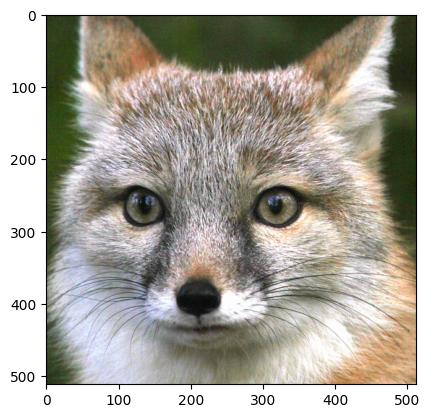

In [2]:
import jax.numpy as np
from jax import jit, grad, random
from jax.example_libraries import stax, optimizers

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import imageio.v2 as imageio

rand_key = random.PRNGKey(0)

# Download image, take a square crop from the center

image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.

c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[(c[0]-r):(c[0]+r), (c[1]-r):(c[1]+r)]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2, ::2], img[::2, ::2]]



# JAX network definition
def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(3))
    layers.append(stax.Sigmoid)
    return stax.serial(*layers)


# Train model with given hyperparameters and data
def train_model(network_size, learning_rate, iters, B, train_data, test_data):

    init_fn, apply_fn = make_network(*network_size)

    model_pred = jit(lambda params, x: apply_fn(params, input_mapping(x, B)))
    model_loss = jit(lambda params, x, y: .5 * np.mean((model_pred(params, x) - y) ** 2))
    model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
    model_grad_loss = jit(lambda params, x, y: grad(model_loss)(params, x, y))

    opt_init, opt_update, get_params = optimizers.adam(learning_rate)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, input_mapping(train_data[0], B).shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)

        if i % 25 == 0:
            train_psnrs.append(model_psnr(get_params(opt_state), *train_data))
            test_psnrs.append(model_psnr(get_params(opt_state), *test_data))
            pred_imgs.append(model_pred(get_params(opt_state), test_data[0]))
            xs.append(i)

    return {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': np.stack(pred_imgs),
        'xs': xs,
    }

network_size = (4, 256)
learning_rate = 1e-4
iters = 200#0

mapping_size = 256



### FFT

In [4]:
iters = 2000

# Fourier feature mapping
def input_mapping(x, B):
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)


B_dict = {
    'none': None, # Standard network - no mapping
    'basic': np.eye(2) # Basic mapping
}

# Three different scales of Gaussian Fourier feature mappings
B_gauss = random.normal(rand_key, (mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale

# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

  0%|          | 0/5 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

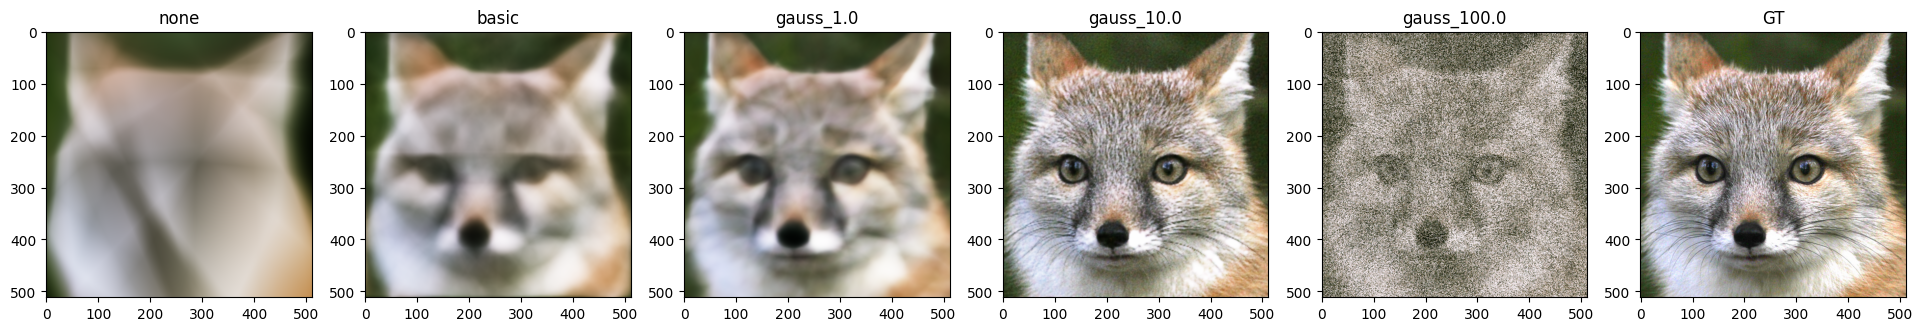

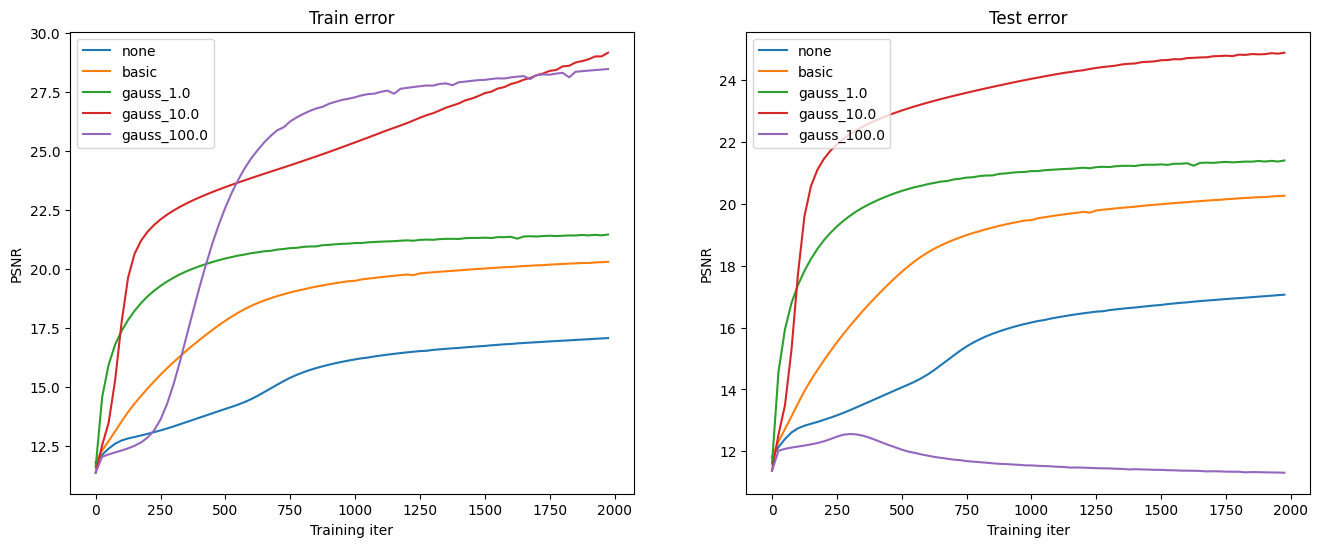

In [5]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [7]:
# 根据先前的实验结果，提取并展示每种特征映射方法的训练和测试PSNR值

# 初始化用于存储结果的字典
results_dict = {}

# 遍历每种特征映射方法的输出，提取训练和测试PSNR值
for key in outputs:
    results_dict[key] = {
        'Train PSNR': outputs[key]['train_psnrs'],
        'Test PSNR': outputs[key]['test_psnrs']
    }

results_dict



{'none': {'Train PSNR': [Array(11.821327, dtype=float32),
   Array(12.14354, dtype=float32),
   Array(12.402487, dtype=float32),
   Array(12.61186, dtype=float32),
   Array(12.748343, dtype=float32),
   Array(12.833067, dtype=float32),
   Array(12.896818, dtype=float32),
   Array(12.958889, dtype=float32),
   Array(13.027837, dtype=float32),
   Array(13.098303, dtype=float32),
   Array(13.17369, dtype=float32),
   Array(13.25586, dtype=float32),
   Array(13.342344, dtype=float32),
   Array(13.433899, dtype=float32),
   Array(13.52696, dtype=float32),
   Array(13.619579, dtype=float32),
   Array(13.712318, dtype=float32),
   Array(13.805896, dtype=float32),
   Array(13.898681, dtype=float32),
   Array(13.992899, dtype=float32),
   Array(14.083803, dtype=float32),
   Array(14.173767, dtype=float32),
   Array(14.269389, dtype=float32),
   Array(14.377514, dtype=float32),
   Array(14.501367, dtype=float32),
   Array(14.642303, dtype=float32),
   Array(14.796676, dtype=float32),
   Array(14

### DCT

In [8]:
iters = 2000

# DCT 映射函數
def dct_1d(x):
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    phi = np.pi / N * (n + 0.5) * k
    return 2 * np.sum(x * np.cos(phi), axis=1)

def dct_2d(x):
    dct_row = np.apply_along_axis(dct_1d, 0, x)
    dct_col = np.apply_along_axis(dct_1d, 1, dct_row)
    return dct_col

def dct_mapping(x):
    height, width, channels = x.shape
    result = []
    for i in range(channels):
        xi = x[:, :, i]
        result.append(dct_2d(xi))
    return np.stack(result, axis=-1)

# 修改後的 input_mapping 函數
def input_mapping(x, B):
    if B is None:
        return x  # 無映射
    else:
        # 高斯 DCT 映射
        x_proj = (2. * np.pi * x) @ B.T
        return dct_mapping(x_proj)


# 更新後的特徵映射字典
B_dict = {
    'none': None,  # 無映射
    'dct_basic': np.eye(2),  # 基本 DCT 映射
}

# Three different scales of Gaussian DCT feature mappings
B_gauss = random.normal(rand_key, (mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale


# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

  0%|          | 0/5 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

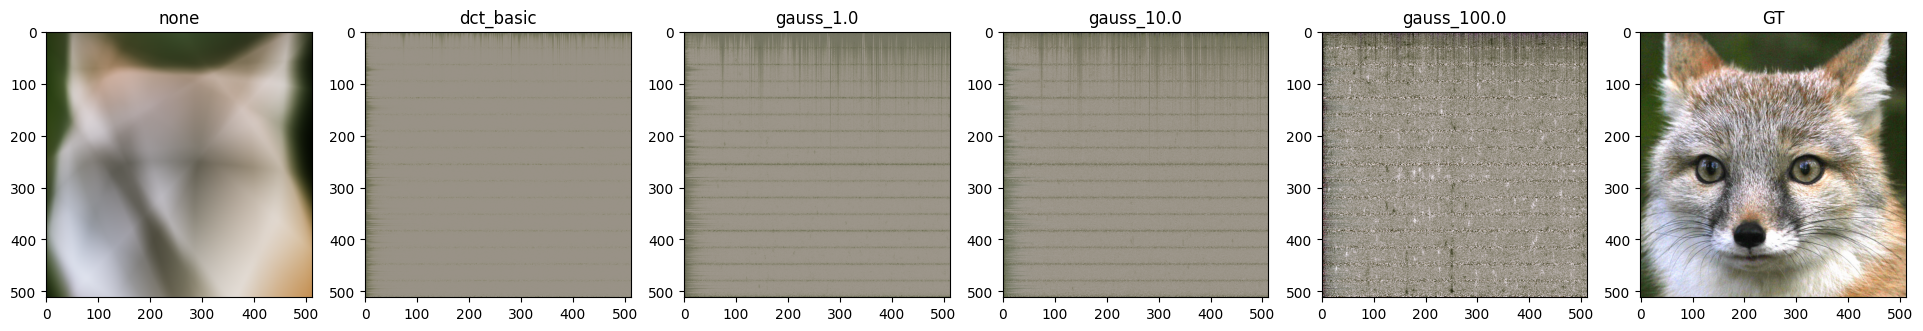

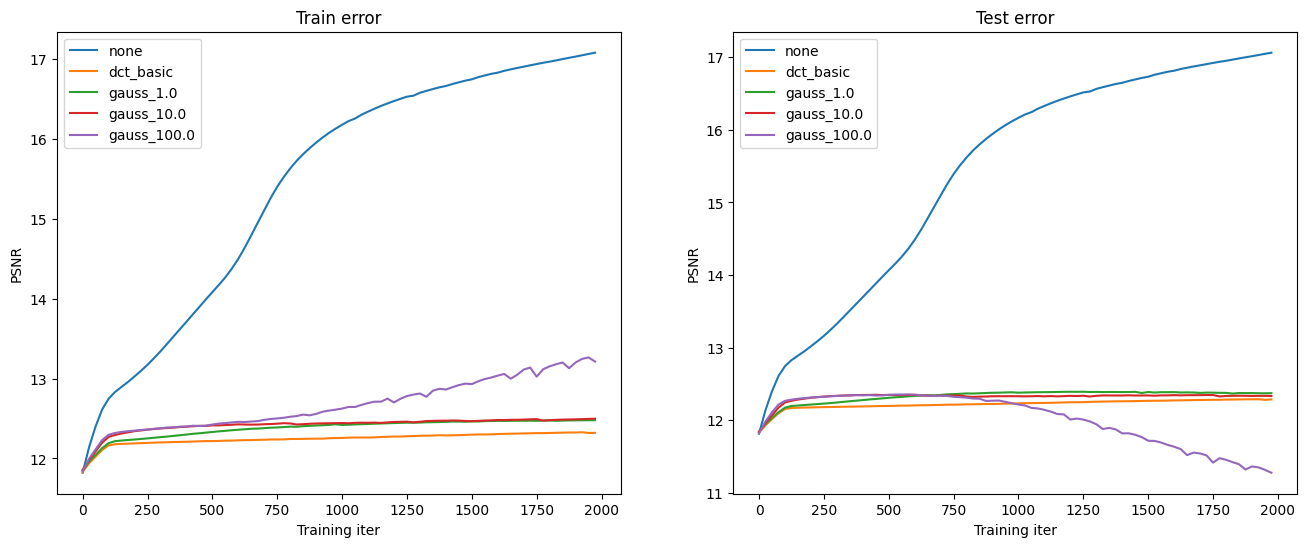

In [9]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [10]:
# 根据先前的实验结果，提取并展示每种特征映射方法的训练和测试PSNR值

# 初始化用于存储结果的字典
results_dict = {}

# 遍历每种特征映射方法的输出，提取训练和测试PSNR值
for key in outputs:
    results_dict[key] = {
        'Train PSNR': outputs[key]['train_psnrs'],
        'Test PSNR': outputs[key]['test_psnrs']
    }

results_dict



{'none': {'Train PSNR': [Array(11.821327, dtype=float32),
   Array(12.14354, dtype=float32),
   Array(12.402487, dtype=float32),
   Array(12.61186, dtype=float32),
   Array(12.748343, dtype=float32),
   Array(12.833067, dtype=float32),
   Array(12.896818, dtype=float32),
   Array(12.958889, dtype=float32),
   Array(13.027837, dtype=float32),
   Array(13.098303, dtype=float32),
   Array(13.17369, dtype=float32),
   Array(13.25586, dtype=float32),
   Array(13.342344, dtype=float32),
   Array(13.433899, dtype=float32),
   Array(13.52696, dtype=float32),
   Array(13.619579, dtype=float32),
   Array(13.712318, dtype=float32),
   Array(13.805896, dtype=float32),
   Array(13.898681, dtype=float32),
   Array(13.992899, dtype=float32),
   Array(14.083803, dtype=float32),
   Array(14.173767, dtype=float32),
   Array(14.269389, dtype=float32),
   Array(14.377514, dtype=float32),
   Array(14.501367, dtype=float32),
   Array(14.642303, dtype=float32),
   Array(14.796676, dtype=float32),
   Array(14

### DWT

In [11]:
import jax.numpy as np
from jax import jit, vmap

iters = 2000

@jit
def haar_wavelet_transform_1d(x):
    N = x.shape[0]
    if N % 2 > 0:
        x = np.pad(x, (0, 1), 'constant')
        N = x.shape[0]

    output = np.zeros(N)
    for i in range(0, N, 2):
        output = output.at[i // 2].set((x[i] + x[i + 1]) / np.sqrt(2))  # Average
        output = output.at[N // 2 + i // 2].set((x[i] - x[i + 1]) / np.sqrt(2))  # Difference

    return output

@jit
def haar_wavelet_transform_2d(x):
    # Apply 1D Haar Wavelet Transform to each row
    transformed_rows = vmap(haar_wavelet_transform_1d)(x)
    # Apply 1D Haar Wavelet Transform to each column
    transformed = vmap(haar_wavelet_transform_1d)(transformed_rows.T).T
    return transformed

@jit
def dwt_mapping(x):
    # Apply Haar Wavelet Transform to each channel
    transformed = vmap(haar_wavelet_transform_2d)(x)
    return transformed

def input_mapping(x, B):
    if B is None:
        return x  # 无映射
    else:
        # 高斯 DWT 映射
        x_proj = (2. * np.pi * x) @ B.T
        return dwt_mapping(x_proj)


# 更新後的特徵映射字典
B_dict = {
    'none': None,  # 無映射
    'dwt_basic': np.eye(2),  # 基本 DWCT 映射
}


# Three different scales of DWT feature mappings
B_gauss = random.normal(rand_key, (mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale


# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

  0%|          | 0/5 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

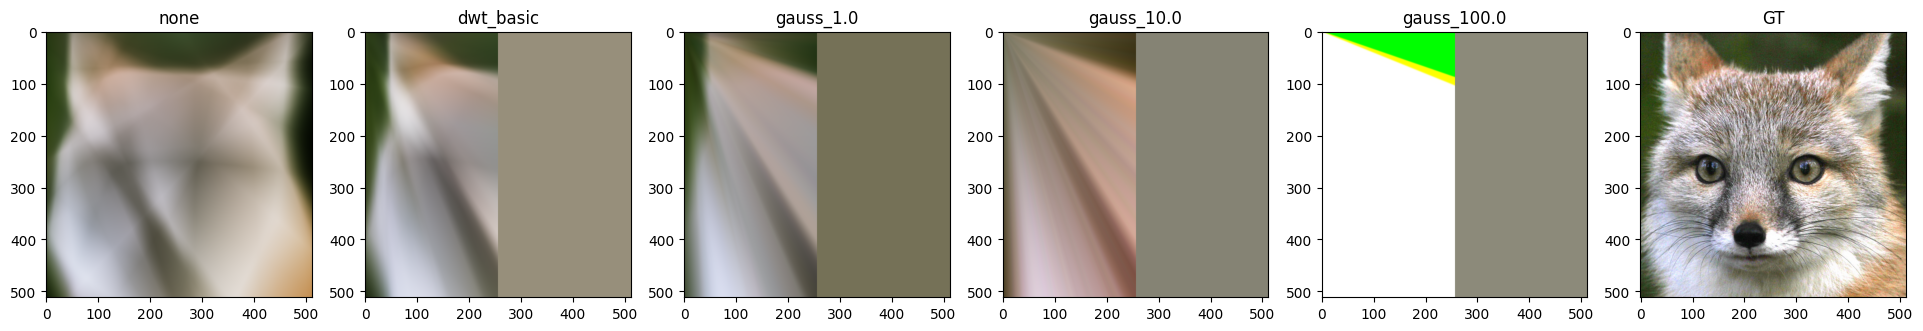

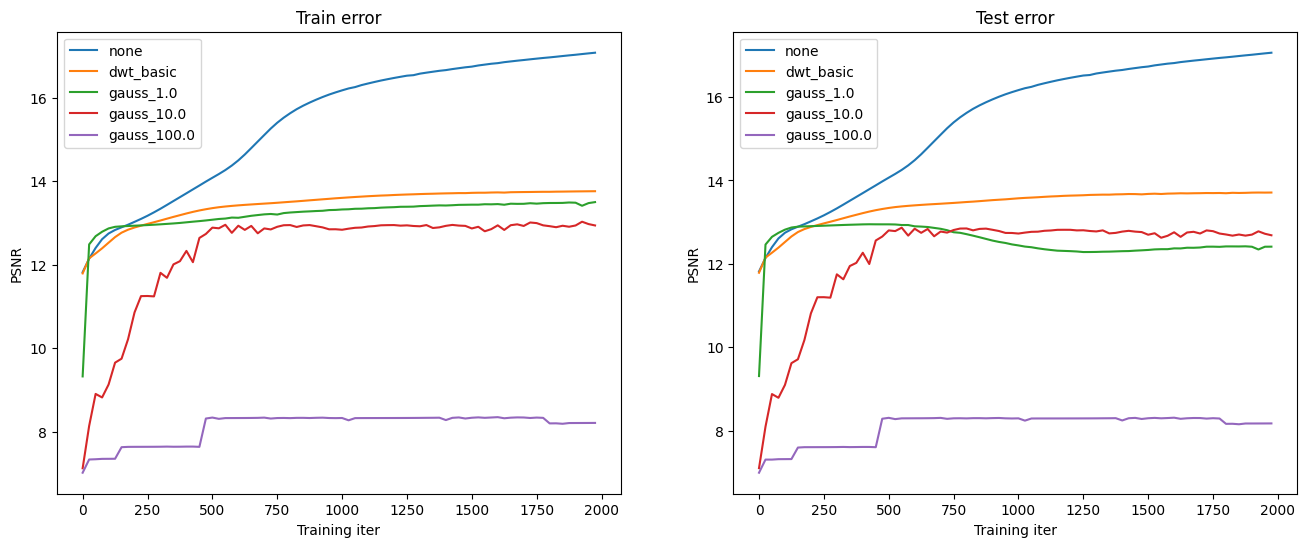

In [12]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [13]:
# 根据先前的实验结果，提取并展示每种特征映射方法的训练和测试PSNR值

# 初始化用于存储结果的字典
results_dict = {}

# 遍历每种特征映射方法的输出，提取训练和测试PSNR值
for key in outputs:
    results_dict[key] = {
        'Train PSNR': outputs[key]['train_psnrs'],
        'Test PSNR': outputs[key]['test_psnrs']
    }

results_dict



{'none': {'Train PSNR': [Array(11.821327, dtype=float32),
   Array(12.14354, dtype=float32),
   Array(12.402487, dtype=float32),
   Array(12.61186, dtype=float32),
   Array(12.748343, dtype=float32),
   Array(12.833067, dtype=float32),
   Array(12.896818, dtype=float32),
   Array(12.958889, dtype=float32),
   Array(13.027837, dtype=float32),
   Array(13.098303, dtype=float32),
   Array(13.17369, dtype=float32),
   Array(13.25586, dtype=float32),
   Array(13.342344, dtype=float32),
   Array(13.433899, dtype=float32),
   Array(13.52696, dtype=float32),
   Array(13.619579, dtype=float32),
   Array(13.712318, dtype=float32),
   Array(13.805896, dtype=float32),
   Array(13.898681, dtype=float32),
   Array(13.992899, dtype=float32),
   Array(14.083803, dtype=float32),
   Array(14.173767, dtype=float32),
   Array(14.269389, dtype=float32),
   Array(14.377514, dtype=float32),
   Array(14.501367, dtype=float32),
   Array(14.642303, dtype=float32),
   Array(14.796676, dtype=float32),
   Array(14